# MBS Trend Convexity Basis Backtest

In [147]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [3]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\MBSTrendConvexity\root\src")
sys.path.append(r"/Users/diegoalvarez/Desktop/research/MBSTrendConvexity/root/src")
from DurationHedge import DurationHedge

## Simplistic and Adaptive MBS Basis

First start by analyzing a simplistic basis strategy of buying the MBS index and short all of the Treasury Futures.

In [117]:
def get_basis() -> pd.DataFrame: 

    df_tsy_prep = (DurationHedge().get_tsy_futures()[
        ["date", "security", "px_bps"]].
        rename(columns = {
            "security": "tsy_fut",
            "px_bps"  : "tsy_bps"}))
    
    df_mbs_prep = (DurationHedge().get_mtge_data()[
        ["px_bps"]].
        reset_index().
        rename(columns = {"px_bps": "mbs_bps"}))
    
    df_out = (DurationHedge().duration_hedge().merge(
        right = df_tsy_prep, how = "inner", on = ["date", "tsy_fut"]).
        merge(right = df_mbs_prep, how = "inner", on = ["date"]).
        assign(spread = lambda x: (x.mbs_bps * x.lag_mbs_weight) - (x.tsy_bps * x.lag_tsy_weight)))

    return df_out

df_basis = get_basis()

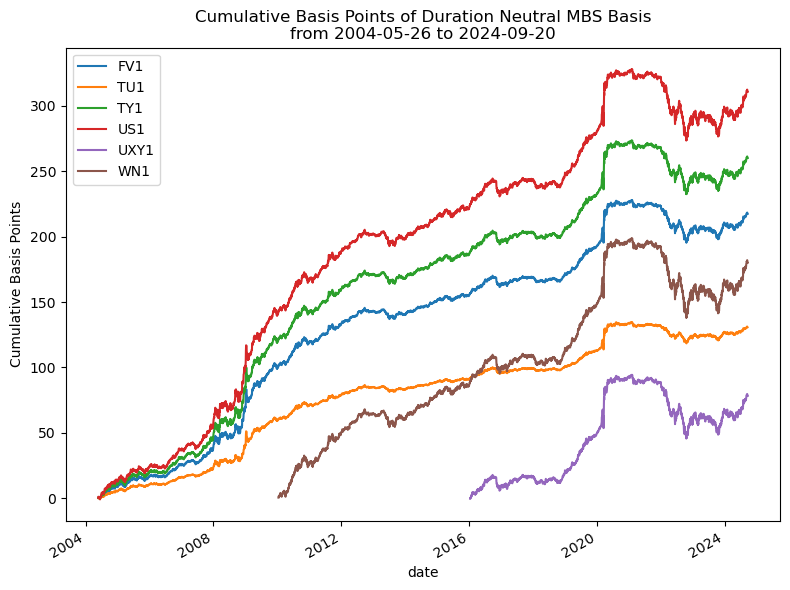

In [119]:
def plot_basis_rtn(df_basis: pd.DataFrame) -> plt.Figure: 

    (df_basis[
        ["date", "tsy_fut", "spread"]].
        rename(columns = {"tsy_fut": ""}).
        pivot(index = "date", columns = "", values = "spread").
        cumsum().
        plot(
            figsize = (8,6),
            ylabel  = "Cumulative Basis Points",
            title   = "Cumulative Basis Points of Duration Neutral MBS Basis\nfrom {} to {}".format(
                df_basis.date.min().date(),
                df_basis.date.max().date())))

    plt.tight_layout()

plot_basis_rtn(df_basis)

In [7]:
def get_basis_sharpe(df_basis: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df_basis[
        ["tsy_fut", "spread"]].
        groupby("tsy_fut").
        agg(["mean", "std"])
        ["spread"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]])

    return df_out

df_sharpe = get_basis_sharpe(df_basis)

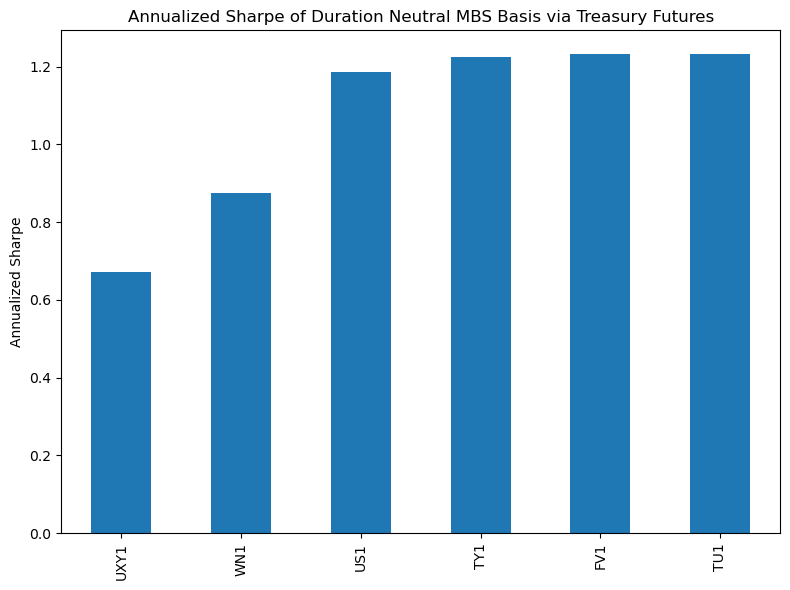

In [8]:
def plot_basis_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 

    (df_sharpe.
        sort_values("sharpe").
        plot(
            kind    = "bar",
            legend  = False,
            ylabel  = "Annualized Sharpe",
            xlabel  = "",
            figsize = (8,6),
            title   = "Annualized Sharpe of Duration Neutral MBS Basis via Treasury Futures"))

    plt.tight_layout()

plot_basis_sharpe(df_sharpe)

In this case an adaptive basis is use where the Treasury Future is found via mean squared error of the duration of the treasury future. 

In [10]:
def get_adaptive_basis() -> pd.DataFrame: 

    df_tsy_tmp = (DurationHedge().get_tsy_futures()[
        ["date", "security", "px_bps"]].
        rename(columns = {
            "security": "lag_tsy",
            "px_bps"  : "tsy_bps"}))
    
    df_mbs_tmp = (DurationHedge().get_mtge_data()[
        ["px_bps"]].
        reset_index().
        rename(columns = {"px_bps": "mbs_bps"}))
    
    df_weight_tmp = (DurationHedge().duration_hedge()[
        ["date", "tsy_fut", "tsy_weight", "mbs_weight"]].
        rename(columns = {"tsy_fut": "lag_tsy"}))
    
    df_out = (DurationHedge().get_matched_future().merge(
        right = df_tsy_tmp, how = "inner", on = ["date", "lag_tsy"]).
        merge(right = df_mbs_tmp,    how = "inner", on = ["date"]).
        merge(right = df_weight_tmp, how = "inner", on = ["date", "lag_tsy"]).
        assign(spread = lambda x: (x.mbs_weight * x.mbs_bps) - (x.tsy_weight * x.tsy_bps)))

    return df_out

df_adaptive_basis = get_adaptive_basis()

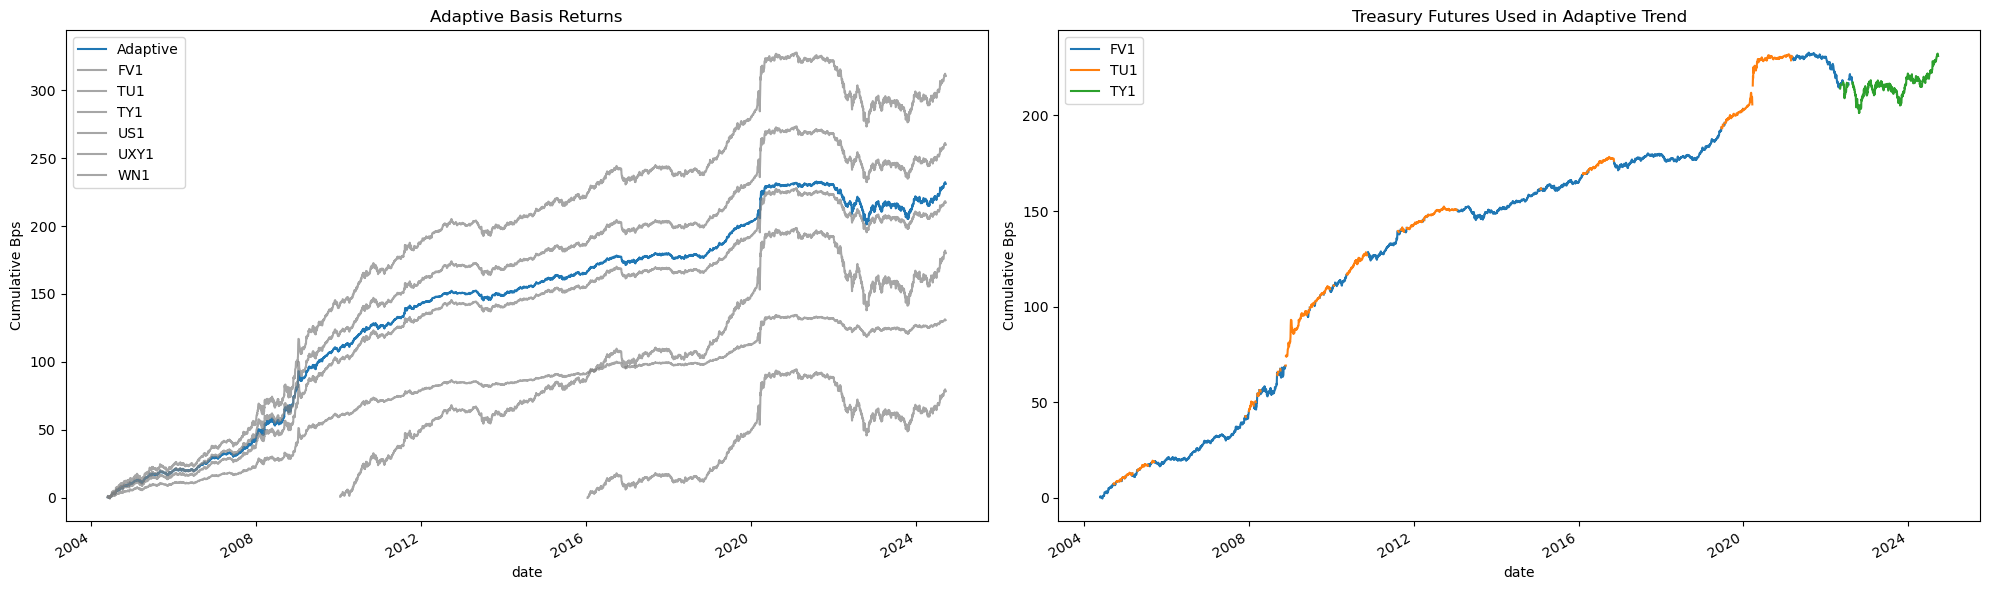

In [11]:
def plot_adaptive_basis(df_adaptive_basis: pd.DataFrame, df_basis: pd.DataFrame) -> plt.Figure: 

    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))
    
    (df_adaptive_basis.set_index(
        "date")
        [["spread"]].
        rename(columns = {"spread": "Adaptive"}).
        cumsum().
        plot(
            ax = axes[0]))
    
    (df_basis[
        ["date", "spread", "tsy_fut"]].
        rename(columns = {"tsy_fut": ""}).
        pivot(index = "date", columns = "", values = "spread").
        cumsum().
        plot(
            ax     = axes[0],
            alpha  = 0.7,
            color  = "grey",
            ylabel = "Cumulative Bps",
            title  = "Adaptive Basis Returns"))
    
    (df_adaptive_basis.sort_values(
        "date").
        assign(cum_spread = lambda x: x.spread.cumsum())
        [["date", "lag_tsy", "cum_spread"]].
        rename(columns = {"lag_tsy": ""}).
        pivot(index = "date", columns = "", values = "cum_spread").
        plot(
            ax     = axes[1],
            ylabel = "Cumulative Bps",
            title  = "Treasury Futures Used in Adaptive Trend"))

    plt.tight_layout()

plot_adaptive_basis(df_adaptive_basis, df_basis)

In [12]:
def get_adaptive_sharpe(df_adaptive_basis: pd.DataFrame, df_basis: pd.DataFrame) -> pd.DataFrame: 

    df_adaptive = (df_adaptive_basis[
        ["date", "spread"]].
        assign(tsy_fut = "Adaptive"))
    
    df_basis_tmp = (df_basis[
        ["date", "tsy_fut", "spread"]])
    
    df_sharpe = (pd.concat([
        df_adaptive, df_basis_tmp]).
        drop(columns = ["date"]).
        groupby("tsy_fut").
        agg(["mean", "std"])
        ["spread"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)))

    return df_sharpe

df_adaptive_sharpe = get_adaptive_sharpe(df_adaptive_basis, df_basis)

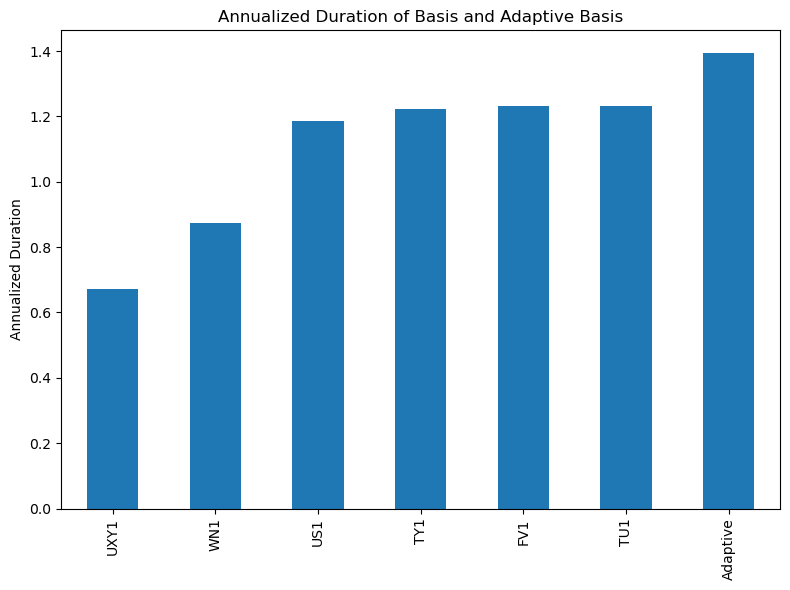

In [13]:
def plot_adaptive_sharpe(df_adaptive_sharpe: pd.DataFrame) -> plt.Figure:

    (df_adaptive_sharpe[
        ["sharpe"]].
        sort_values("sharpe").
        plot(
            kind    = "bar",
            xlabel  = "",
            legend  = False,
            ylabel  = "Annualized Duration",
            title   = "Annualized Duration of Basis and Adaptive Basis",
            figsize = (8,6)))
    
    plt.tight_layout()

plot_adaptive_sharpe(df_adaptive_sharpe)

## Naive Basis Strategy: Long MBS Basis and Long Treasury CTA Background

Unfortunately the Societe Generale Interest Rate Trend index can't be expressed into basis points since there is a lack of duration data. In this case the index will be expressed in nominal difference and the rest will be calculated in 

Need to redo this for the basis points returns of the strategy and not the synthetic index that i created. 

In [239]:
def prep_strats(df_adaptive_basis: pd.DataFrame, df_basis: pd.DataFrame) -> pd.DataFrame: 

    df_basis_tmp = (df_basis[
        ["date", "tsy_fut", "spread"]].
        rename(columns = {
            "tsy_fut": "strat",
            "spread" : "signal_bps"}).
        assign(strat = lambda x: "MBS Basis: " + x.strat))
    
    df_adaptive = (df_adaptive_basis[
        ["date", "spread"]].
        assign(strat = "MBS Basis: Adaptive").
        rename(columns = {"spread": "signal_bps"}))
    
    df_trend = (DurationHedge().get_tsy_signal()[
        ["date", "security", "signal_bps"]].
        rename(columns = {"security": "strat"}).
        assign(strat = lambda x: "Trend: " + x.strat))
    
    df_replicator = (DurationHedge().replicate_sg_index().reset_index().assign(
        SocGenTrend = lambda x: x.SocGenTrend.diff()).
        melt(id_vars = "date").
        rename(columns = {
            "variable": "strat",
            "value"   : "signal_bps"}).
        assign(strat = lambda x: "Trend: " + x.strat))
    
    df_out = (pd.concat([
        df_basis_tmp,
        df_adaptive,
        df_trend,
        df_replicator]))

    return df_out

df_strats = prep_strats(df_adaptive_basis, df_basis)

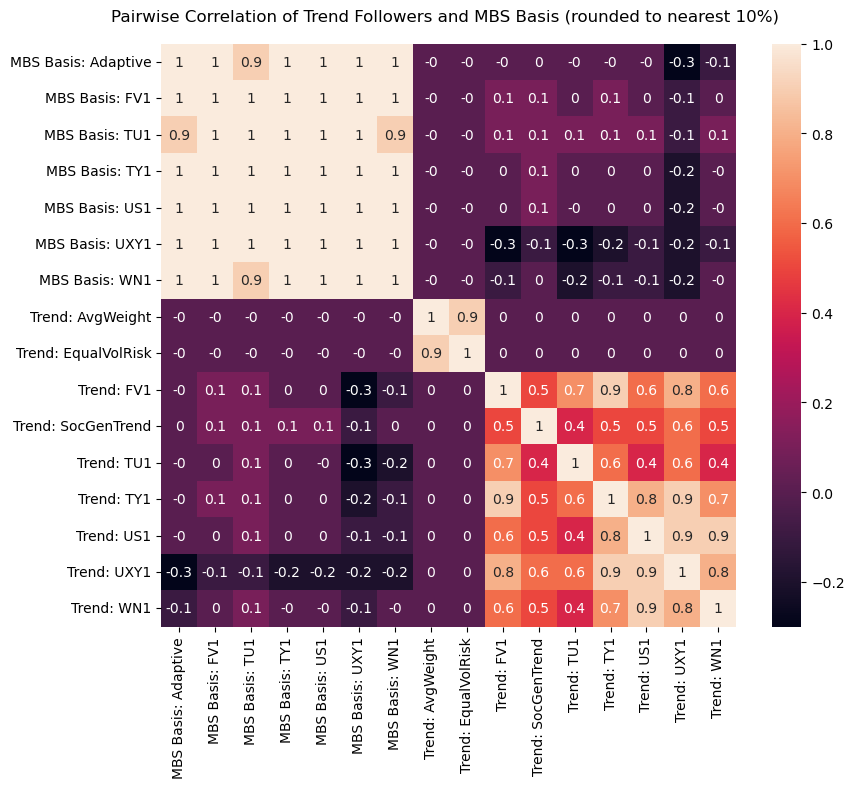

In [241]:
def plot_strat_correlation(df_strats: pd.DataFrame) -> plt.Figure: 

    fig, axes = plt.subplots(figsize = (9,8))
    
    df_corr = (df_strats.pivot(
        index = "date", columns = "strat", values = "signal_bps").
        corr().
        apply(lambda x: np.round(x,1)))
    
    sns.heatmap(
        data  = df_corr,
        ax    = axes,
        annot = True)

    axes.set_xlabel("")
    axes.set_ylabl
    
    fig.suptitle("Pairwise Correlation of Trend Followers and MBS Basis (rounded to nearest 10%)")
    plt.tight_layout()

plot_strat_correlation(df_strats)

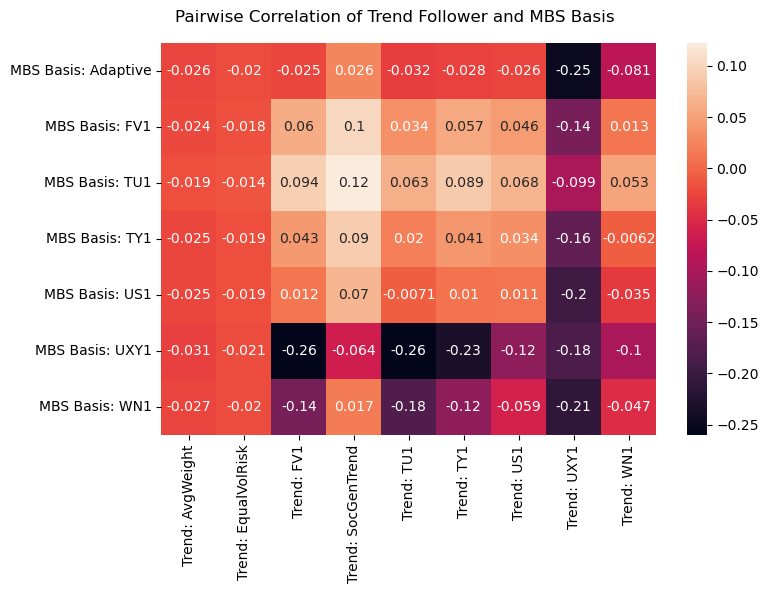

In [249]:
def get_pairwise_correlation(df_strats: pd.DataFrame) -> plt.Figure: 

    df_tmp = (df_strats.pivot(
        index = "date", columns = "strat", values = "signal_bps").
        corr().
        reset_index().
        rename(columns = {"strat": "strat1"}).
        melt(id_vars = "strat1").
        query("strat1 != strat").
        assign(
            first  = lambda x: x.strat1.str.split(" ").str[0].str.replace(":", ""),
            second = lambda x: x.strat.str.split(" ").str[0].str.replace(":", "")).
        query("first != second").
        drop(columns = ["first", "second"]).
        groupby("value").
        head(1).
        pivot(index = "strat", columns = "strat1", values = "value"))
    
    fig, axes = plt.subplots(figsize = (8,6))
    
    sns.heatmap(
        data  = df_tmp,
        ax    = axes,
        annot = True)
    
    axes.set_xlabel("")
    axes.set_ylabel("")
    fig.suptitle("Pairwise Correlation of Trend Follower and MBS Basis")
    
    plt.tight_layout()

get_pairwise_correlation(df_strats)